Basic LSTM Model to predict Avocado Prices


Import and clean

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
# Import csv file prices_prod
source_df = pd.read_csv('./Resources/prices_prod.csv', parse_dates=['date'], index_col= 'date' )
source_df.reset_index(inplace=True)
source_df.sort_index(inplace=True)
source_df.head()
source_df.dropna()

,date,year_month,geography,type,avg_price,prices_total_volume,units_4046,units_4225,units_4770,total_bags,s_bags,l_bags,xl_bags,status,prod_total_volume,california,chile,mexico,peru,colombia
0,2018-01-07,1/1/2018,Albany,conventional,1.13,98540.22,2940.63,76192.61,42.63,19364.35,8633.09,10707.93,23.33,actual,45670156,899349,519433,44251374,0,0
1,2018-01-07,1/1/2018,Albany,organic,1.54,4816.90,43.51,412.17,0.00,4361.22,4357.89,3.33,0.00,actual,45670156,899349,519433,44251374,0,0
2,2018-01-07,1/1/2018,Atlanta,conventional,0.98,713915.80,364463.12,47869.41,1459.65,300123.62,217644.43,78287.66,4191.53,actual,45670156,899349,519433,44251374,0,0
3,2018-01-07,1/1/2018,Atlanta,organic,1.53,15714.11,405.37,4195.19,0.00,11113.55,7883.61,3229.94,0.00,actual,45670156,899349,519433,44251374,0,0
4,2018-01-07,1/1/2018,Baltimore/Washington,conventional,1.50,771313.78,89883.07,466602.79,4167.07,210660.85,189304.53,21356.32,0.00,actual,45670156,899349,519433,44251374,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14467,2020-09-06,9/1/2020,TotalUS,organic,1.62,1754057.30,105106.37,144137.69,4186.01,1500627.23,848427.68,652190.75,8.80,actual,52693480,8453470,0,39925907,4314102,0
14468,2020-09-06,9/1/2020,West,conventional,0.95,9026449.59,1975837.16,1152252.54,33199.60,5864954.14,2726358.78,3060566.48,78028.88,actual,52693480,8453470,0,39925907,4314102,0
14469,2020-09-06,9/1/2020,West,organic,1.58,315771.42,31032.50,28880.42,1192.43,254666.07,100807.93,153849.34,8.80,actual,52693480,8453470,0,39925907,4314102,0
14470,2020-09-06,9/1/2020,WestTex/NewMexico,conventional,0.75,1212992.28,397029.46,76486.29,39407.07,700069.46,482659.19,215394.65,2015.62,actual,52693480,8453470,0,39925907,4314102,0


In [6]:
# Drop the non-beneficial columns, 'status' and 'prod'.
source_df.drop(['year_month', 'status'],axis=1, inplace=True)
source_df.head()

,date,geography,type,avg_price,prices_total_volume,units_4046,units_4225,units_4770,total_bags,s_bags,l_bags,xl_bags,prod_total_volume,california,chile,mexico,peru,colombia
0,2018-01-07,Albany,conventional,1.13,98540.22,2940.63,76192.61,42.63,19364.35,8633.09,10707.93,23.33,45670156,899349,519433,44251374,0,0
1,2018-01-07,Albany,organic,1.54,4816.90,43.51,412.17,0.00,4361.22,4357.89,3.33,0.00,45670156,899349,519433,44251374,0,0
2,2018-01-07,Atlanta,conventional,0.98,713915.80,364463.12,47869.41,1459.65,300123.62,217644.43,78287.66,4191.53,45670156,899349,519433,44251374,0,0
3,2018-01-07,Atlanta,organic,1.53,15714.11,405.37,4195.19,0.00,11113.55,7883.61,3229.94,0.00,45670156,899349,519433,44251374,0,0
4,2018-01-07,Baltimore/Washington,conventional,1.50,771313.78,89883.07,466602.79,4167.07,210660.85,189304.53,21356.32,0.00,45670156,899349,519433,44251374,0,0


In [7]:
# Correct the type catagory
source_df.loc[source_df['type'] == 'conventional ', 'type'] = 'conventional'
source_df.groupby('type').size()

type
conventional    7236
organic         7236
dtype: int64

In [8]:
source_df["date"] = pd.to_datetime(source_df["date"])
source_df['year'] = source_df['date'].dt.year
source_df['month'] = source_df['date'].dt.month
source_df['day'] = source_df['date'].dt.day

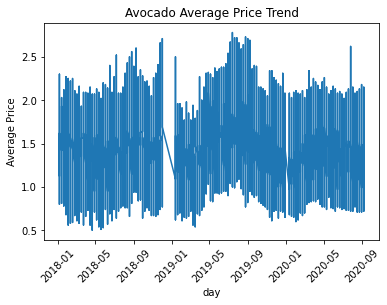

In [9]:
# Plot avg_price by time
fig, ax = plt.subplots()
ax.plot(source_df.date, source_df.avg_price)
ax.set(xlabel='day', ylabel='Average Price', title="Avocado Average Price Trend")
plt.xticks(rotation='45')
plt.show()

In [10]:
lstmregconv_df = source_df.loc[source_df['type'] == 'conventional']
lstmregconv_df = source_df[['date', 'avg_price']]
lstmregorg_df = source_df.loc[source_df['type'] == 'organic']
lstmregorg_df = source_df[['date', 'avg_price']]
#lstmregorg_df.tail(75)
lstmregconv_df.tail(75)

,date,avg_price
14397,2020-09-06,1.60
14398,2020-09-06,1.19
14399,2020-09-06,2.15
14400,2020-09-06,0.77
14401,2020-09-06,1.30
...,...,...
14467,2020-09-06,1.62
14468,2020-09-06,0.95
14469,2020-09-06,1.58
14470,2020-09-06,0.75


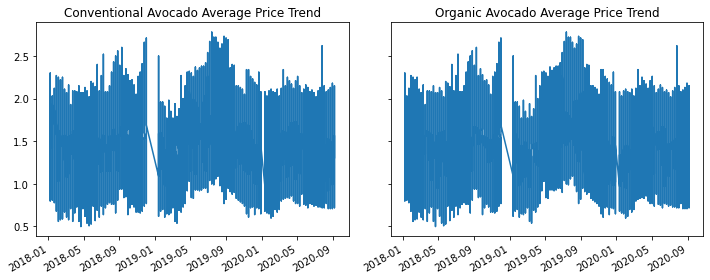

In [11]:
# 1st plot
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(10, 4))
ax1.plot(lstmregconv_df.date, lstmregconv_df.avg_price)
ax1.set_title('Conventional Avocado Average Price Trend')
ax2.plot(lstmregorg_df.date, lstmregorg_df.avg_price)
ax2.set_title('Organic Avocado Average Price Trend')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

LSTM Processing for conventional Avocada data

In [12]:
# Drop the date to fit LSTM model.
lstmregconv_df.drop(['date'],axis=1, inplace=True)
lstmregconv_df.head()

C:\Users\David\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,avg_price
0,1.13
1,1.54
2,0.98
3,1.53
4,1.50


In [13]:
# fix random seed for reproducibility
np.random.seed(1)

In [14]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
lstmregconv_df= scaler.fit_transform(lstmregconv_df)

In [15]:
lstmregconv_df

array([[0.27631579],
       [0.45614035],
       [0.21052632],
       ...,
       [0.47368421],
       [0.10964912],
       [0.46491228]])

In [16]:
# split into train and test sets
train_size = int(len(lstmregconv_df) * 0.67)
test_size = len(lstmregconv_df) - train_size
train, test = lstmregconv_df[0:train_size,:], lstmregconv_df[train_size:len(lstmregconv_df),:]
print(len(train), len(test))

9696 4776


In [17]:
# convert an array of values into a dataset matrix
def create_dataset(lstmregconv_df, look_back=1):
    dataX, dataY = [], []
    for i in range(len(lstmregconv_df)-look_back-1):
        a = lstmregconv_df[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(lstmregconv_df[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
create_dataset(lstmregconv_df, 1)

(array([[0.27631579],
        [0.45614035],
        [0.21052632],
        ...,
        [0.49122807],
        [0.19736842],
        [0.47368421]]),
 array([0.45614035, 0.21052632, 0.45175439, ..., 0.19736842, 0.47368421,
        0.10964912]))

In [18]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [19]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
9694/9694 - 8s - loss: 0.0242
Epoch 2/50
9694/9694 - 8s - loss: 0.0224
Epoch 3/50
9694/9694 - 8s - loss: 0.0223
Epoch 4/50
9694/9694 - 8s - loss: 0.0223
Epoch 5/50
9694/9694 - 8s - loss: 0.0223
Epoch 6/50
9694/9694 - 8s - loss: 0.0223
Epoch 7/50
9694/9694 - 8s - loss: 0.0223
Epoch 8/50
9694/9694 - 8s - loss: 0.0223
Epoch 9/50
9694/9694 - 8s - loss: 0.0223
Epoch 10/50
9694/9694 - 8s - loss: 0.0223
Epoch 11/50
9694/9694 - 8s - loss: 0.0222
Epoch 12/50
9694/9694 - 8s - loss: 0.0222
Epoch 13/50
9694/9694 - 8s - loss: 0.0223
Epoch 14/50
9694/9694 - 8s - loss: 0.0222
Epoch 15/50
9694/9694 - 8s - loss: 0.0223
Epoch 16/50
9694/9694 - 8s - loss: 0.0222
Epoch 17/50
9694/9694 - 8s - loss: 0.0222
Epoch 18/50
9694/9694 - 8s - loss: 0.0222
Epoch 19/50
9694/9694 - 8s - loss: 0.0222
Epoch 20/50
9694/9694 - 8s - loss: 0.0222
Epoch 21/50
9694/9694 - 8s - loss: 0.0222
Epoch 22/50
9694/9694 - 8s - loss: 0.0223
Epoch 23/50
9694/9694 - 8s - loss: 0.0222
Epoch 24/50
9694/9694 - 9s - loss: 0.0222
E

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.34 RMSE
Test Score: 0.32 RMSE


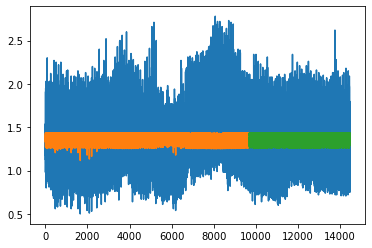

In [22]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(lstmregconv_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(lstmregconv_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(lstmregconv_df)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(lstmregconv_df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

LSTM Processing for organic Avocada data

In [23]:
# Drop the date to fit LSTM model.
lstmregorg_df.drop(['date'],axis=1, inplace=True)
lstmregorg_df.head()

C:\Users\David\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,avg_price
0,1.13
1,1.54
2,0.98
3,1.53
4,1.50


In [24]:
# fix random seed for reproducibility
np.random.seed(1)

In [25]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
lstmregorg_df= scaler.fit_transform(lstmregorg_df)

In [26]:
lstmregorg_df

array([[0.27631579],
       [0.45614035],
       [0.21052632],
       ...,
       [0.47368421],
       [0.10964912],
       [0.46491228]])

In [27]:
# split into train and test sets
train_size = int(len(lstmregorg_df) * 0.67)
test_size = len(lstmregorg_df) - train_size
train, test = lstmregorg_df[0:train_size,:], lstmregorg_df[train_size:len(lstmregorg_df),:]
print(len(train), len(test))

9696 4776


In [28]:
# convert an array of values into a dataset matrix
def create_dataset(lstmregorg_df, look_back=1):
    dataX, dataY = [], []
    for i in range(len(lstmregorg_df)-look_back-1):
        a = lstmregorg_df[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(lstmregorg_df[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
create_dataset(lstmregorg_df, 1)

(array([[0.27631579],
        [0.45614035],
        [0.21052632],
        ...,
        [0.49122807],
        [0.19736842],
        [0.47368421]]),
 array([0.45614035, 0.21052632, 0.45175439, ..., 0.19736842, 0.47368421,
        0.10964912]))

In [29]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [30]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
9694/9694 - 8s - loss: 0.0240
Epoch 2/100
9694/9694 - 8s - loss: 0.0224
Epoch 3/100
9694/9694 - 8s - loss: 0.0223
Epoch 4/100
9694/9694 - 8s - loss: 0.0223
Epoch 5/100
9694/9694 - 8s - loss: 0.0223
Epoch 6/100
9694/9694 - 8s - loss: 0.0223
Epoch 7/100
9694/9694 - 8s - loss: 0.0223
Epoch 8/100
9694/9694 - 8s - loss: 0.0223
Epoch 9/100
9694/9694 - 8s - loss: 0.0223
Epoch 10/100
9694/9694 - 8s - loss: 0.0222
Epoch 11/100
9694/9694 - 8s - loss: 0.0223
Epoch 12/100
9694/9694 - 8s - loss: 0.0223
Epoch 13/100
9694/9694 - 8s - loss: 0.0222
Epoch 14/100
9694/9694 - 8s - loss: 0.0223
Epoch 15/100
9694/9694 - 8s - loss: 0.0222
Epoch 16/100
9694/9694 - 8s - loss: 0.0223
Epoch 17/100
9694/9694 - 8s - loss: 0.0222
Epoch 18/100
9694/9694 - 8s - loss: 0.0222
Epoch 19/100
9694/9694 - 8s - loss: 0.0222
Epoch 20/100
9694/9694 - 8s - loss: 0.0222
Epoch 21/100
9694/9694 - 8s - loss: 0.0222
Epoch 22/100
9694/9694 - 8s - loss: 0.0222
Epoch 23/100
9694/9694 - 8s - loss: 0.0222
Epoch 24/100
9694/96

In [32]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.34 RMSE
Test Score: 0.32 RMSE


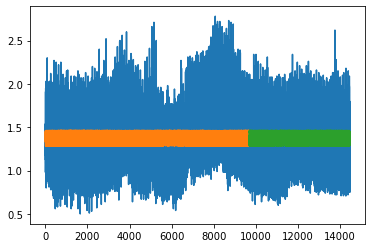

In [33]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(lstmregorg_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(lstmregorg_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(lstmregorg_df)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(lstmregorg_df
                                 ))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

LSTM Processing for all Avocada data

In [34]:
# Drop the date to fit LSTM model.
all_data_df = pd.DataFrame(source_df['avg_price'])
all_data_df


,avg_price
0,1.13
1,1.54
2,0.98
3,1.53
4,1.50
...,...
14467,1.62
14468,0.95
14469,1.58
14470,0.75


In [35]:
# fix random seed for reproducibility
np.random.seed(1)

In [36]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
all_data_df= scaler.fit_transform(all_data_df)

In [37]:
# split into train and test sets
train_size = int(len(all_data_df) * 0.67)
test_size = len(all_data_df) - train_size
train, test = all_data_df[0:train_size,:], all_data_df[train_size:len(all_data_df),:]
print(len(train), len(test))

9696 4776


In [38]:
# convert an array of values into a dataset matrix
def create_dataset(all_data_df, look_back=1):
    dataX, dataY = [], []
    for i in range(len(all_data_df)-look_back-1):
        a = all_data_df[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(all_data_df[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
create_dataset(all_data_df, 1)

(array([[0.27631579],
        [0.45614035],
        [0.21052632],
        ...,
        [0.49122807],
        [0.19736842],
        [0.47368421]]),
 array([0.45614035, 0.21052632, 0.45175439, ..., 0.19736842, 0.47368421,
        0.10964912]))

In [39]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [40]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [41]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
9694/9694 - 9s - loss: 0.0235
Epoch 2/100
9694/9694 - 9s - loss: 0.0226
Epoch 3/100
9694/9694 - 9s - loss: 0.0225
Epoch 4/100
9694/9694 - 9s - loss: 0.0224
Epoch 5/100
9694/9694 - 9s - loss: 0.0224
Epoch 6/100
9694/9694 - 9s - loss: 0.0223
Epoch 7/100
9694/9694 - 9s - loss: 0.0223
Epoch 8/100
9694/9694 - 9s - loss: 0.0223
Epoch 9/100
9694/9694 - 9s - loss: 0.0223
Epoch 10/100
9694/9694 - 9s - loss: 0.0223
Epoch 11/100
9694/9694 - 9s - loss: 0.0223
Epoch 12/100
9694/9694 - 9s - loss: 0.0222
Epoch 13/100
9694/9694 - 9s - loss: 0.0222
Epoch 14/100
9694/9694 - 9s - loss: 0.0222
Epoch 15/100
9694/9694 - 9s - loss: 0.0222
Epoch 16/100
9694/9694 - 9s - loss: 0.0221
Epoch 17/100
9694/9694 - 9s - loss: 0.0221
Epoch 18/100
9694/9694 - 9s - loss: 0.0221
Epoch 19/100
9694/9694 - 9s - loss: 0.0221
Epoch 20/100
9694/9694 - 9s - loss: 0.0220
Epoch 21/100
9694/9694 - 9s - loss: 0.0220
Epoch 22/100
9694/9694 - 9s - loss: 0.0220
Epoch 23/100
9694/9694 - 9s - loss: 0.0220
Epoch 24/100
9694/96

In [42]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.34 RMSE
Test Score: 0.33 RMSE


In [43]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(all_data_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(trainPredictPlot = np.empty_like(all_data_df))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredictPlot = np.empty_like(all_data_df)
)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(trainPredictPlot = np.empty_like(all_data_df)

                                  
                                 ))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

TypeError: empty_like() got an unexpected keyword argument 'trainPredictPlot'